In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['figure.figsize'] = 12,8

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy.ma as ma
from scipy.optimize import curve_fit

In [2]:
def get_data(file_name):
    '''
    gets the Qx, Qy, Qz as 3 1D arrays
    '''
    data = np.genfromtxt(file_name, dtype=float, delimiter=None,
                         skip_header=2, names=["Qx", "Qy", "I(Qx,Qy)", "err(I)"])
    shape_x = len(np.unique(data['Qx']))
    shape_y = len(np.unique(data['Qy']))
    data_x = data['Qx']  # .reshape(shape_x, shape_y)
    data_y = data['Qy']  # .reshape(shape_x, shape_y)
    data_z = data['IQxQy']  # .reshape(shape_x, shape_y)
    return data_x, data_y, data_z

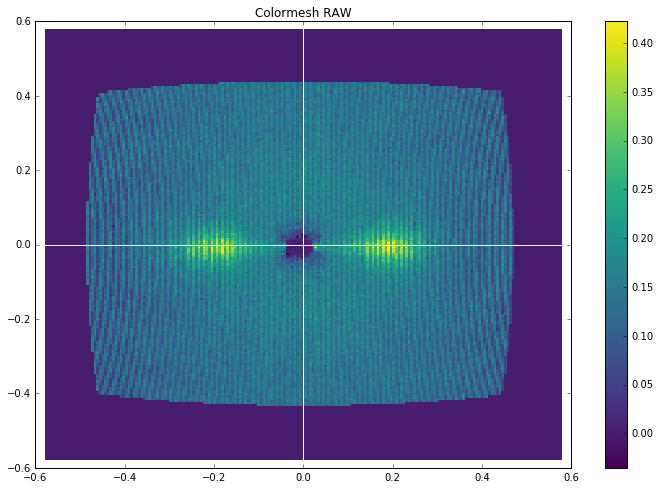

In [3]:
data_x, data_y, data_z = get_data("./Bio-SANS/anisotropy_with-peak/high-q-has_peak/BioSANS_exp317_scan0021_0001_Iqxy.dat")

# Reshape the data as 2D
shape_x = len(np.unique(data_x))
shape_y = len(np.unique(data_y))
X = data_x.reshape(shape_x, shape_y)
Y = data_y.reshape(shape_x, shape_y)
Z = data_z.reshape(shape_x, shape_y)
plt.title("Colormesh RAW")
plt.pcolormesh(X, Y, Z)
plt.axhline(y=0,color='w')
plt.axvline(x=0,color='w')
plt.colorbar()


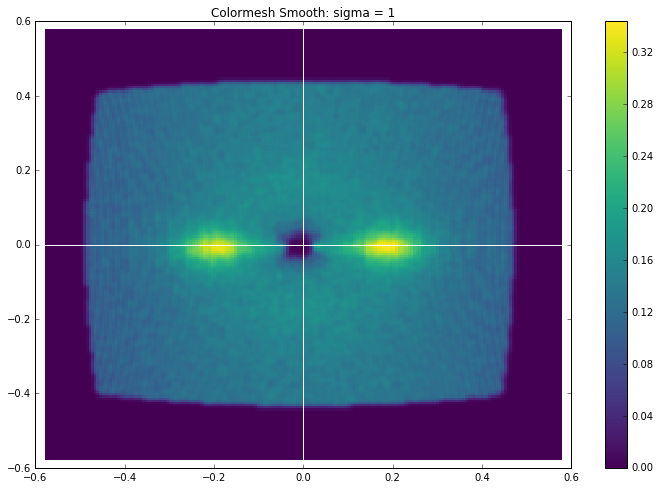

In [4]:
# Image smoothing to get rid of the stripes
from scipy.ndimage import filters
Z_smooth = filters.gaussian_filter(Z, sigma=1)
plt.title("Colormesh Smooth: sigma = 1")
plt.pcolormesh(X, Y, Z_smooth)
plt.axhline(y=0,color='w')
plt.axvline(x=0,color='w')
plt.colorbar()

In [5]:
def sector_average(data_x, data_y, data_z, 
                   n_bins_angle=100, n_bins_radius=50, max_radius = np.inf):
    '''
    Sector averaging
    n_bins_angle: (x coordinates)
    n_bins_radius: Q (y coordinates)
    data_? : 1D arrays
    '''
    radius = np.linalg.norm(np.column_stack((data_x, data_y)), axis=1)

    angle = np.arctan2(data_y, data_x)
    angle = np.rad2deg(angle)
    # make it integer from 0 to 360
    angle = np.round(angle).astype(int) + 180
    

    # normalize data to 1
#     data_z = (data_z - data_z.min()) / (data_z.max() - data_z.min())
#     data_z = (data_z)**(1/2)
    
    # limit radius
    angle = angle[radius <= max_radius]
    data_z =data_z[radius <= max_radius]
    radius = radius[radius <= max_radius]

    H, xedges, yedges, binnumber = stats.binned_statistic_2d(angle, radius, data_z,
                                       bins=[n_bins_angle, n_bins_radius],
                                       statistic='mean')

    xedges_width = (xedges[1] - xedges[0])
    xedges_center = xedges[1:] - xedges_width / 2

    yedges_width = (yedges[1] - yedges[0])
    yedges_center = yedges[1:] - yedges_width / 2

    xedges_center = np.linspace(np.amin(xedges_center), np.amax(xedges_center), len(xedges_center))

    return H, xedges_center, yedges_center


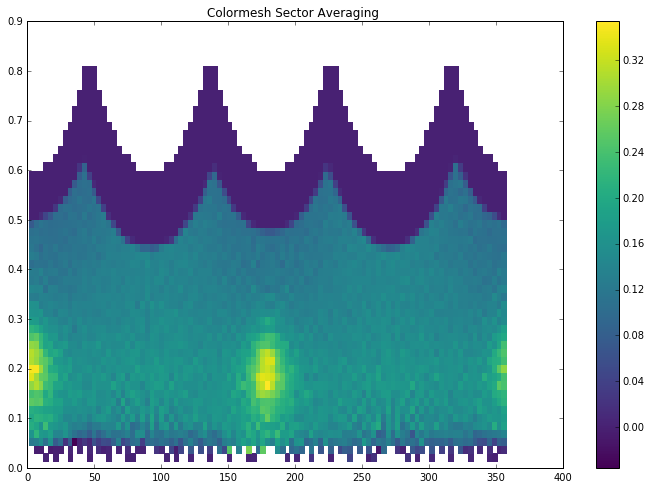

In [6]:
# Sectors
# Mask NaNs
H, x, y = sector_average(data_x, data_y, data_z)
X_sectors, Y_sectors = np.meshgrid(x, y)
H_masked_nans = ma.masked_where(np.isnan(H),H)
plt.title("Colormesh Sector Averaging ")
plt.pcolormesh(X_sectors, Y_sectors, H_masked_nans.T)
plt.colorbar()

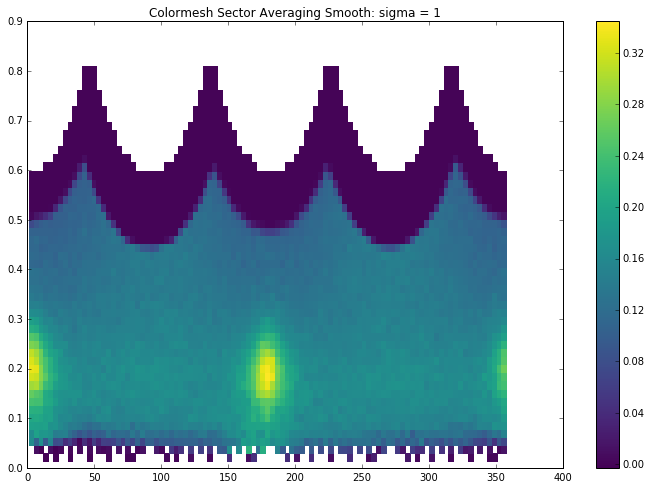

In [7]:
# Let's do the same with smoothing
# Sectors
from scipy.ndimage import filters
data_z_smooth = filters.gaussian_filter(data_z, sigma=1)

H, x, y = sector_average(data_x, data_y, data_z_smooth)
X_sectors, Y_sectors = np.meshgrid(x, y)
H_masked_nans = ma.masked_where(np.isnan(H),H)
plt.title("Colormesh Sector Averaging Smooth: sigma = 1")
plt.pcolormesh(X_sectors, Y_sectors, H_masked_nans.T)
plt.colorbar()

In [8]:
from scipy.ndimage import filters
data = H.T

In [9]:
def find_peaks_in_2d_image(data, initial_neighborhood_size = 10):
    '''
    Finds peaks (maxima) in the image.
    Stops when 3 peaks are found
    return a matrix of booleans where peaks are True
    '''
    number_of_found_peaks = np.inf
    neighborhood_size = initial_neighborhood_size
    while number_of_found_peaks > 3:
        data_max = filters.maximum_filter(data, neighborhood_size)
        cond = data_max==data
        number_of_found_peaks = np.count_nonzero(cond == True)        
        neighborhood_size+=1
    print("Found {} peaks in the 2D image.".format(number_of_found_peaks))
    return cond
    

Found 3 peaks in the 2D image.


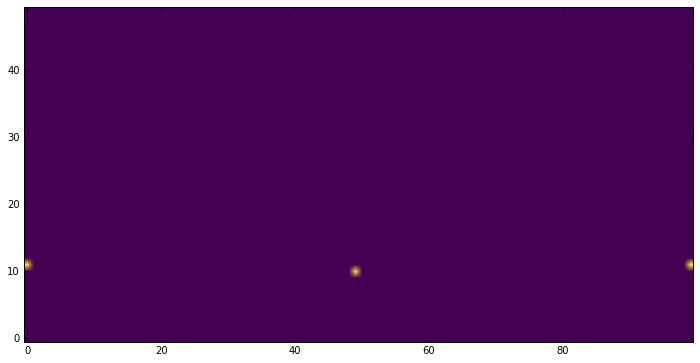

In [10]:
# Plot Maximumns found for the neighborhood_size
cond = find_peaks_in_2d_image(data)
plt.imshow(cond,origin='lower')

Peak positions in indices: (array([10, 11, 11]), array([49,  0, 99]))


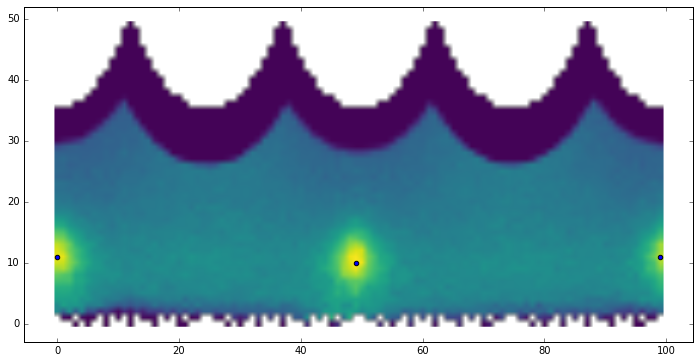

In [11]:
# Overlay Maximum indices over the plot
indices = cond.nonzero()
print("Peak positions in indices: {}".format(indices))
plt.imshow(data,origin='lower')
plt.scatter(indices[1],indices[0])


Index of maximum = (10, 49).


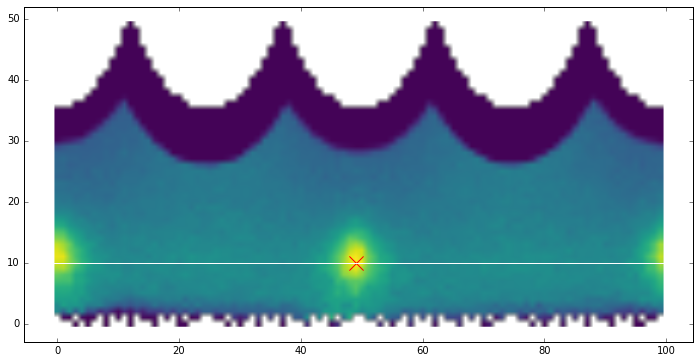

In [12]:
# From the maxima, find the maximum value!
values = np.where(cond, data, -1) 
index_of_max = np.unravel_index(np.argmax(values),values.shape)
print("Index of maximum = {}.".format(index_of_max))
plt.imshow(data,origin='lower')
# Put a cross at the maximum
plt.scatter(index_of_max[1],index_of_max[0],color='r',marker='x', s= 200)
plt.axhline(y=index_of_max[0],color='w')

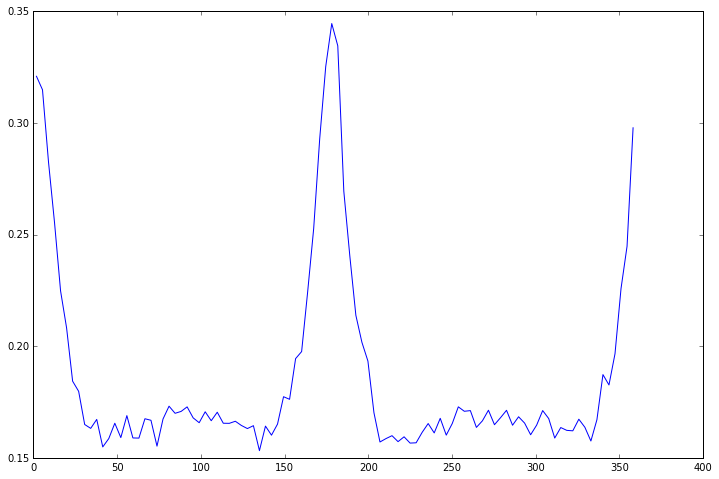

In [14]:
# plot horizontal cut in 1D
horizontal_cut = data[index_of_max[0],:]
plt.plot(x,horizontal_cut)

In [15]:
# Define model function to be used to fit to the data later:
def gauss(x, *p):
    A, mu, sigma, base = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + base

The peak is at 20 degrees
The Amplitude at the peak is at 0.34456109349147696
[  1.70788681e-01   1.77658785e+02   9.67846900e+00   1.63706253e-01]


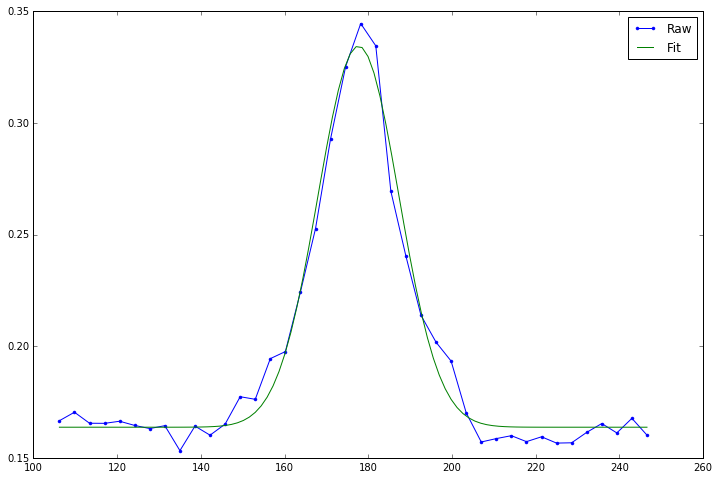

In [19]:
# fitting around the maximum
# get rid of both ends

end_left = index_of_max[1] - 20
end_right = index_of_max[1] + 20
x_trimmed = x[end_left:end_right]
horizontal_cut_trimmed = horizontal_cut[end_left:end_right]

max_idx = np.argmax(horizontal_cut_trimmed)
print("The peak is at {} degrees".format(max_idx))
print("The Amplitude at the peak is at {}".format(horizontal_cut[index_of_max[1]]))

# p0 is the initial guess for the fitting coefficients (A, mu, sigma, vertical offset)
p0 = [horizontal_cut[index_of_max[1]], x_trimmed[max_idx], 5, 0.2]


coeff, var_matrix = curve_fit(gauss, x_trimmed, horizontal_cut_trimmed, p0=p0)


x_fit = np.linspace(x_trimmed[0],x_trimmed[-1],100)
# Get the fitted curve
fit = gauss(x_fit, *coeff)


plt.plot(x_trimmed, horizontal_cut_trimmed, marker='.', label='Raw')
plt.plot(x_fit, fit, label='Fit')
plt.legend()
print(coeff)

In [20]:
print("A = {:4,.2f}, mu = {:4,.2f} (degrees), sigma = {:4,.2f}, vertical offset = {:4,.2f}".format(*coeff))
# Let's get some variables
center = coeff[1]
std_deviation = coeff[2]

A = 0.17, mu = 177.66 (degrees), sigma = 9.68, vertical offset = 0.16


In [21]:
# I'm not using this
def fwhm(sigma):
    '''
    Full width at half maximum
    '''
    return 2 * np.sqrt(2*np.log(2))*sigma

fwhm_value = fwhm(coeff[2])
print(fwhm_value)

22.7910528101


Radial average centred at 177.66 degrees with 45.58 degrees aperture.
Radial average centred at 267.66 degrees with 134.42 degrees aperture.


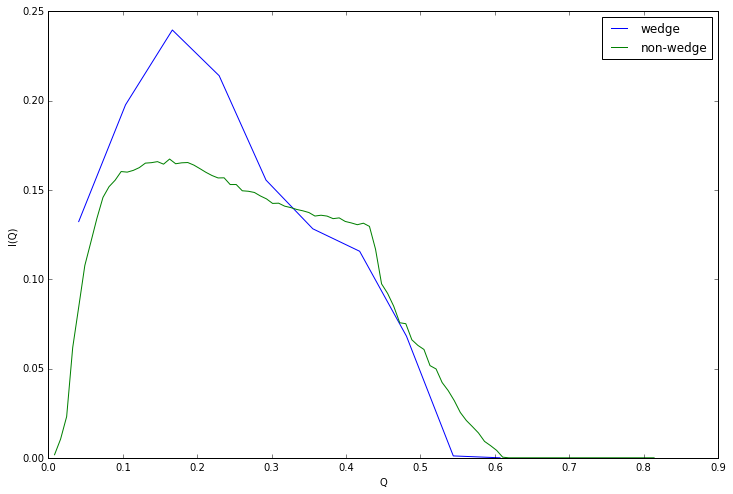

In [34]:
def radial_average(data_x, data_y, data_z, 
                   n_bins_angle=100,
                   max_radius = np.inf, # Q
                   center_angle=0, # degrees
                   width_angle=20,  # degrees
                  ):
    '''
    data_? are 1D arrays
    '''
    
    center_angle %= 360
    width_angle %= 360
        
    print("Radial average centred at {:,.2f} degrees with {:,.2f} degrees aperture.".format(center_angle,width_angle))
    
    # Radius is Q
    radius = np.linalg.norm(np.column_stack((data_x, data_y)), axis=1)

    angle = np.arctan2(data_y, data_x)
    angle = np.rad2deg(angle)
    # make it integer from 0 to 360
    angle = np.round(angle).astype(int) + 180

    

#     # normalize data to 1
#     data_z = (data_z - data_z.min()) / (data_z.max() - data_z.min())
#     data_z = (data_z)**(1/2)

    # Let's duplicate the data so we have 0 to 720 degrees
    angle = np.concatenate([angle,angle+360])
    data_z = np.tile(data_z, 2)
    radius = np.tile(radius, 2)

    
    # Let's limit
    # Radius
    angle = angle[radius <= max_radius]
    data_z =data_z[radius <= max_radius]
    radius = radius[radius <= max_radius]
    # angle
    angle_cond = ((angle >= center_angle - width_angle/2) & \
                  (angle <= center_angle + width_angle/2)) | \
                  ((angle >= (center_angle + 180) - width_angle/2) & \
                   (angle <= (center_angle + 180) + width_angle/2))
    
    angle = angle[angle_cond]
    data_z =data_z[angle_cond]
    radius = radius[angle_cond]
    
#     plt.figure()
#     plt.plot(angle,data_z,'r.')
#     plt.show()
    

    H, xedges, binnumber = stats.binned_statistic(radius,
                                                  data_z,
                                       bins=n_bins_angle,
                                       statistic='mean')

    xedges_width = (xedges[1] - xedges[0])
    xedges_center = xedges[1:] - xedges_width / 2



    xedges_center = np.linspace(np.amin(xedges_center), np.amax(xedges_center), len(xedges_center))
    return H, xedges_center

# Wedge

H, x = radial_average(data_x, data_y, data_z,
                      n_bins_angle=10,
                      max_radius = np.inf, # Q
                      center_angle=center, # degrees
                      width_angle=2*fwhm_value)

plt.figure()
plt.plot(x,H,label="wedge")
plt.xlabel("Q")
plt.ylabel("I(Q)")

# Non wedge
H, x = radial_average(data_x, data_y, data_z,
                      n_bins_angle=100,
                      max_radius = np.inf, # Q
                      center_angle=center+90, # degrees
                      width_angle=180-2*fwhm_value)

plt.plot(x,H,label="non-wedge")
plt.legend()



# Annulus

2 concentric circles... different approach!


In [ ]:
def annulus(data_x, data_y, data_z, 
                   n_bins=100, min_radius=0.1, max_radius = 0.3):
    
    radius = np.linalg.norm(np.column_stack((data_x, data_y)), axis=1)

    angle = np.arctan2(data_y, data_x)
    angle = np.rad2deg(angle)
    # make it integer from 0 to 360
    angle = np.round(angle).astype(int) + 180
    
    radius_condition = (radius <= max_radius) & (radius >= min_radius)
    angle = angle[radius_condition]
    
    # normalize data to 1
    data_z = (data_z - data_z.min()) / (data_z.max() - data_z.min())
    data_z = data_z[radius_condition]
    
    H, edges, binnumber = stats.binned_statistic(angle, data_z,
                                       bins=n_bins,statistic='mean')

    edges_width = (edges[1] - edges[0])
    edges_center = edges[1:] - edges_width / 2

    edges_center = np.linspace(np.amin(edges_center), np.amax(edges_center), len(edges_center))

    return H, edges_center

In [ ]:
# annulus (bins in between 2 circles)
H, x = annulus(data_x, data_y, data_z,n_bins=100, min_radius=0.05, max_radius = 0.4)
plt.plot(x,H,c='b',label="0.05<q<0.4")
H, x = annulus(data_x, data_y, data_z,n_bins=100, min_radius=0.1, max_radius = 0.3)
plt.plot(x,H,c='r',label="0.1<q<0.3")
H, x = annulus(data_x, data_y, data_z,n_bins=100, min_radius=0.15, max_radius = 0.25)
plt.plot(x,H,c='g',label="0.15<q<0.25")
plt.legend()

In [ ]:
# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [0.4, 180., 5, 0.4]

coeff, var_matrix = curve_fit(gauss, x, H, p0=p0)

# Get the fitted curve
fit = gauss(x, *coeff)


plt.plot(x, H, label='Raw')
plt.plot(x, fit, label='Fit')
plt.legend()
print(coeff)